# Electromagnetic wave absorption by a plasma ramp
## Result analyser

To Plot ZDF data files you must first import the ZDF module

In [1]:
import numpy as np
import nb_hlpr
from IPython.display import HTML

First you need to select the data files that correspond to your simulation using the file chooser below.
<br> You may also specify the data type (*e.g* "charge")

You can also choose to plot a single quantity or two at the same time on the "Settings" tab.



In [38]:
tab=nb_hlpr.tabmaker()
tab

### Visualization

Here you can use the slider to advance or go backwards in time

In [106]:
ylims=[[0,0],[0,0]]
fils=[]
nb_hlpr.shower(tab,ylims,fils)[0]

<function nb_hlpr.pltinteract.<locals>.pltstf>

In [5]:
fils

['/mnt/c/Users/MIGUEL/Documents/ninhodospardais/ZPIC/zpic-master-2/zpic-master/em1d/test/cc2/EMF/E3-025040.zdf',
 '/mnt/c/Users/MIGUEL/Documents/ninhodospardais/ZPIC/zpic-master-2/zpic-master/em1d/test/cc2/electrons/charge-025040.zdf']

You may also produce a video

In [42]:
anim=nb_hlpr.animate(tab,ylims)
HTML(anim.to_html5_video())

[250.0, 350.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


And save it using a name of your choice, choose wisely as it can't be changed later

In [43]:
anim.save("prfct.mp4",fps=30)

# Comparison with expected results

The theory behind elctromagnetic wave absorption by a plasma tells us that the <br>
the wave can penetrate the plasma up until a given length which depends btoh <br>
on the frequency of the wave and the plasma density. This length is called the<br>
penetration length:<br>

$\large{\delta=\frac{c}{\sqrt{\omega_{pe}^2-\omega^2}}}$

this happens only if the wave's frequency is smaller than the plasma frequency, $\omega_{pe}$, <br>
if on the other hand, the wave's frequency is larger than the plasma frequency, the <br> wave is
able to propagate normally.

Therefore, if the the plasma density is not constant (*e.g* increasing density) the <br>
wave may propagate normally up until a certain point and then start  decaying, <br> as shown in
the next figure:

<img src="exemp.png"  style="width: 50%; float: left;" />

The shape of the wave function is described by the Airy function, given by:

$ Ai(\eta)={\large \frac{1}{\pi}}{\large\int_0^\infty}\cos{\left({\large \frac{t^3}{3}}-\eta t\right)}dt $

where $\eta=\left({\large \frac{\omega}{c\sqrt{L}}}\right)^{2/3}(x-x_{tp})$ for a collionless plasma with density $n(x)=n_c\large\frac{x}{L}$.

\*$n_c$ is the critical density for the wave frequency $\omega$, *i.e.*, the densty for which <br> the wave no longer propagates and starts to be absorbed

The Airy Function can be approximated by more treatable functions like <br>
cosines (for the left part) and exponentials (for the right part), however, the <br> transition 
region is poorly approximated by any of these functions as you can see below:
<img src="Mplwp_airyai_asymptotic.svg"  style="width: 50%; float: left;" />

You can find out more about the Airy Function on its wikipedia page 
(https://en.wikipedia.org/wiki/Airy_function) <br>
but for now all you need to know is that the approxiamtion  goes as follows: <br>

$ Ai(\eta)\simeq{\large \frac{1}{\pi^{1/2}(-\eta)^{1/4}}}\cos{\left({{\large\frac{2}{3}}(-\eta)^{3/2}}-{\large\frac{\pi}{4}}\right)}dt, \;\;\text{for}\;\eta\ll -1$ 


$ Ai(\eta)\simeq{\large \frac{1}{\pi^{1/2}(\eta)^{1/4}}}\exp{\left({{\large-\frac{2}{3}}(\eta)^{3/2}}\right)}dt, \;\;\text{for}\;\eta\gg 1$ 


The fuinction is defined below:

In [44]:
def Emfun(x, A, L,E0):
    y=np.zeros(len(x))
    for i, xi in enumerate(x): 
        if xi <= L:
            y[i] =  E0/(np.sqrt(np.pi*np.sqrt(-A*(xi-L))))*np.cos(2/3*(-A*(xi-L))**1.5-np.pi/4)
        elif xi >= L:
            y[i] = E0*0.5/np.sqrt(np.pi*np.sqrt(A*(xi-L)))*np.exp(-2/3*(A*(xi-L))**1.5)  
    return y

In order to verify this theory, you can either fit your simulation results to the Airy function, <br>
or directly compare to the expected results using the parameters that you defined on the inputdeck.

## Fit

Start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

After that you must identify the region where the aproximations don't hold using the following tool


In [107]:
file1=fils[1]
file2=fils[0]

datavec=[]

nb_hlpr.intregsel(file1,file2,datavec)

<function nb_hlpr.regselect>

In [46]:
ret=nb_hlpr.paramaker()
param=ret[1]
display(ret[0])

In [109]:
display((1.0653157961516158**1.5)*np.sqrt(29.86746854800489))
((1.0653157961516158**1.5)*np.sqrt(29.86746854800489))**2/29.86746854800489

6.0092013685713708

1.2090244953301266

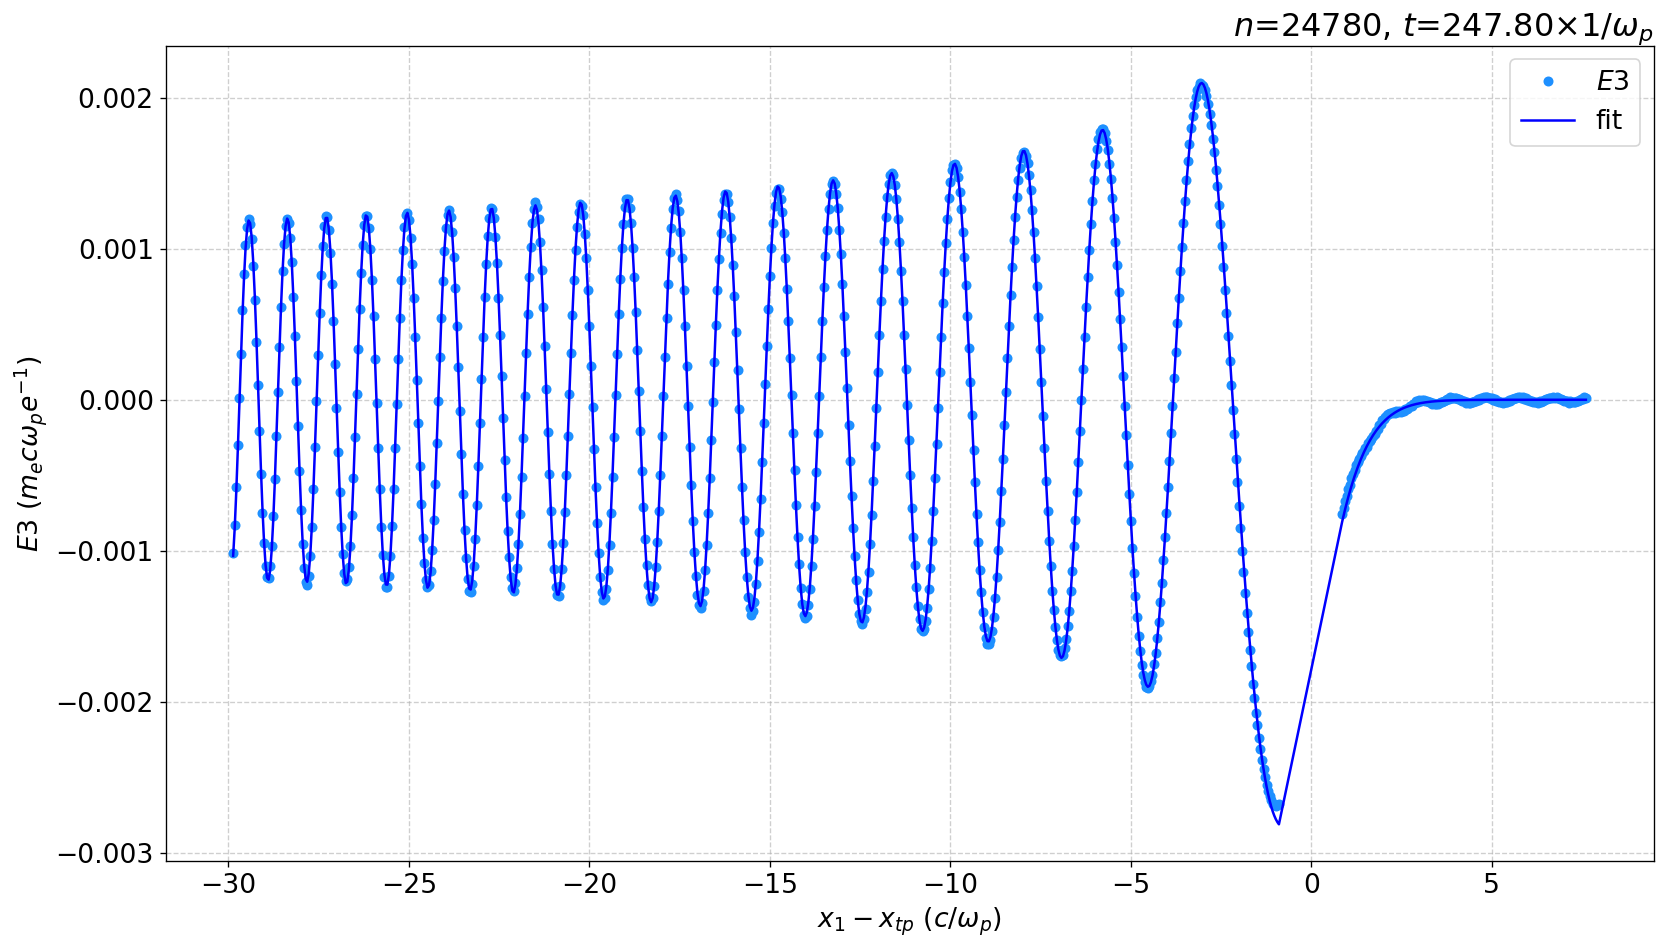

In [108]:
nb_hlpr.fiter(datavec,param,Emfun,save=True)    

## Direct comparison

Once again, start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

In [7]:
dcomp=nb_hlpr.dircompars()
dparam=dcomp[1]
display(dcomp[0])

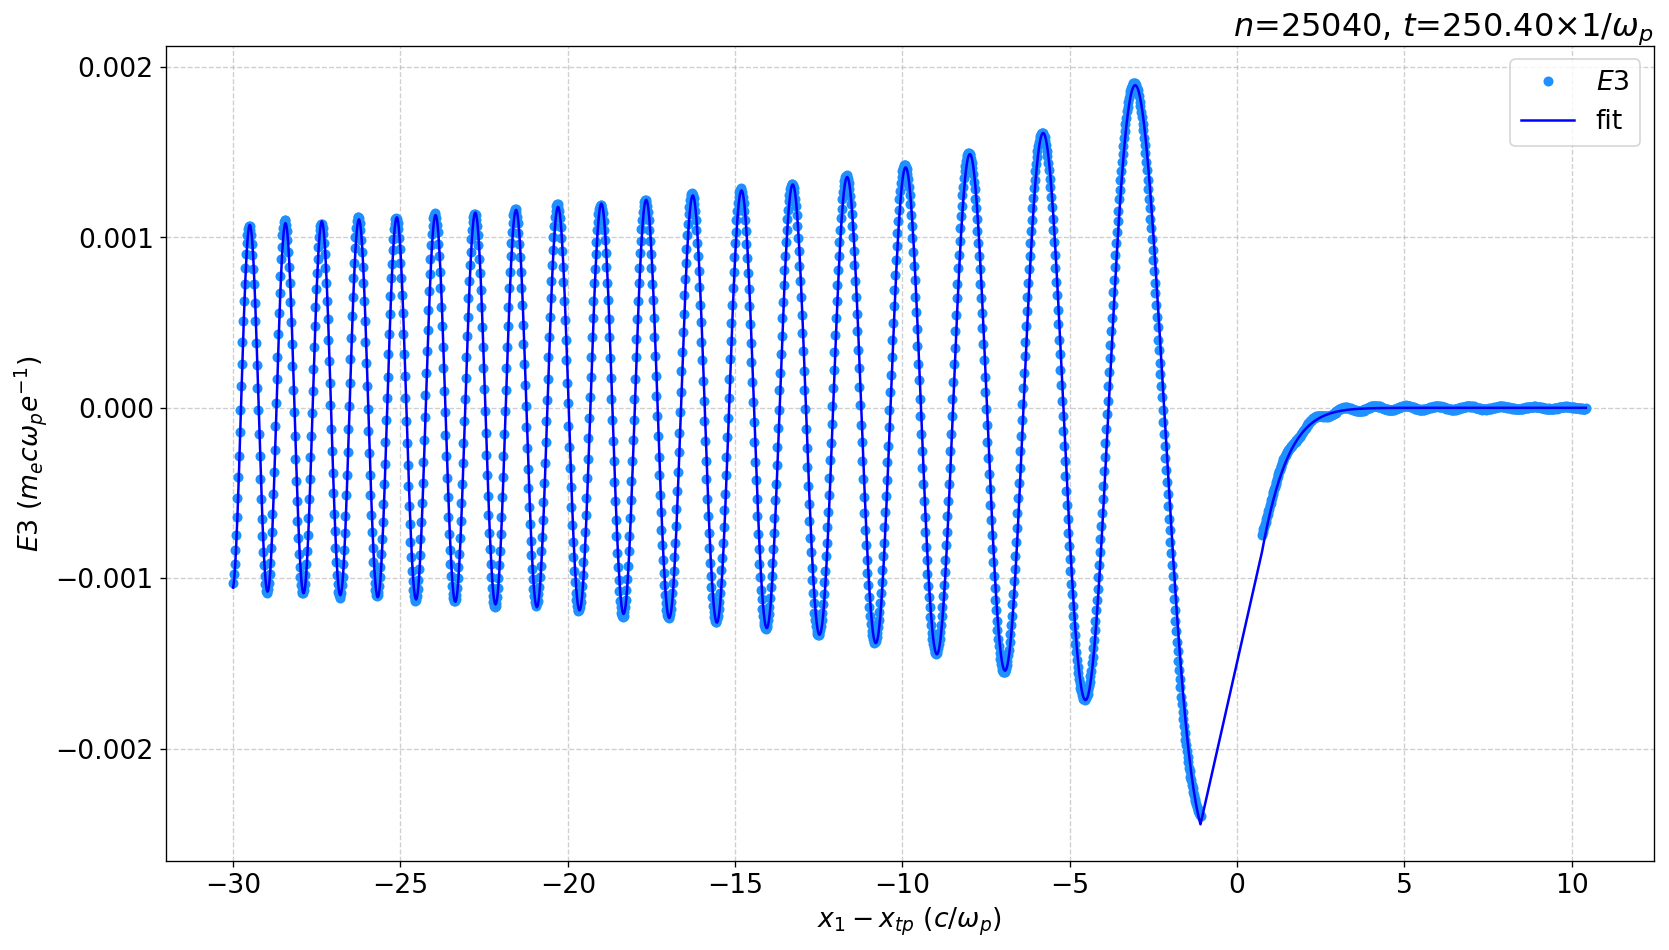

In [54]:
nb_hlpr.dircomp(datavec,dparam,Emfun,save=True)

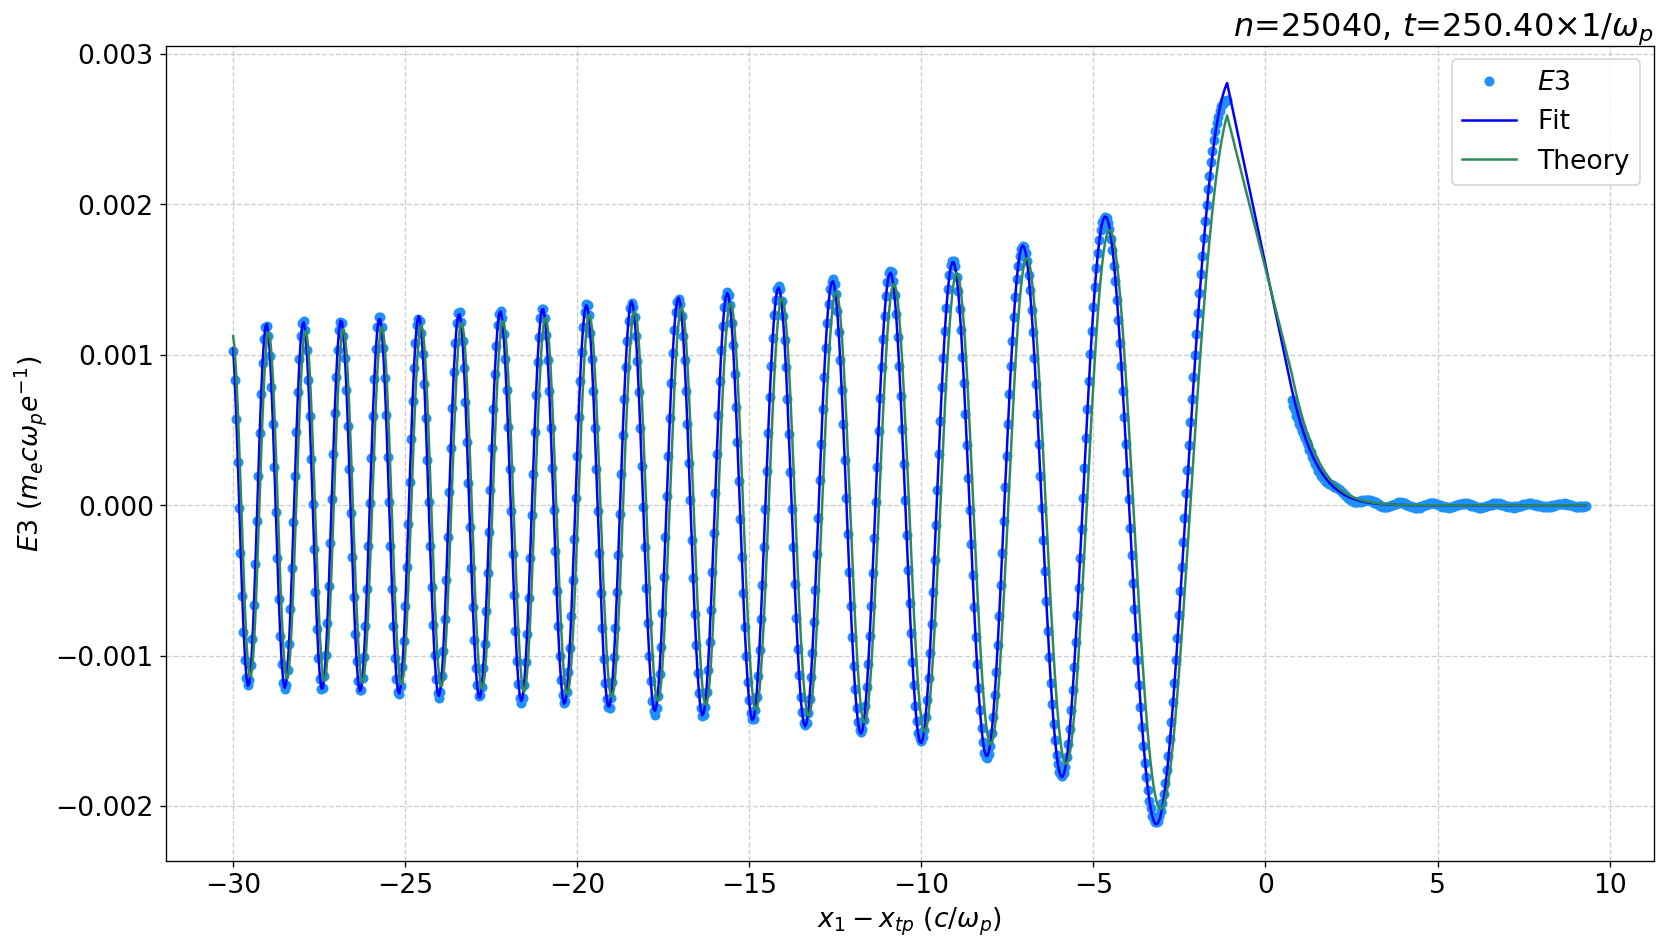

In [8]:
nb_hlpr.fitdircomp(datavec,dparam,param,Emfun,save=False)

In [102]:
import os
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,Layout

import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation

from zdf import zdf_read_grid, zdf_read_particles
import matplotlib.patches as patches
from scipy.optimize import curve_fit


def fitdircomp(datav,param,fitparam,Emfun,save=False):
    plt.clf()
    plt.cla()
    plt.close()
    datavec=datav
    fig=plt.figure(figsize=(16, 9), dpi= 120, facecolor='w', edgecolor='k');
    matplotlib.rcParams.update({'font.size': 16})
    plt.grid(alpha=0.6,linestyle='dashed')
    info=datav[2]
    ax1=plt.gca()
    
        #lines.append(ax1.plot(xx,data,'+',c="coral")[0]);
    ax1.set_title("$n$="+str(info['iteration']['n'])+", $t$="+'{:.2f}'.format(info['iteration']['t'])+"$\\times"+info['iteration']['tunits']+"$",loc='right')
    #ax1.set_xlim([xmin,xmax])
    ax1.set_xlabel("$"+info['grid']['axis'][0]['label']+"-x_{tp}$"+" ($"+info['grid']['axis'][0]['units']+"$)")
    ax1.set_ylabel("$"+info['grid']['label']+"$"+" ($"+info['grid']['units']+"$)")

    L=(param[0].value**2)/param[1].value
    A=(param[0].value/np.sqrt(L))**(2/3)
    E0=(param[2].value*param[1].value)
    
    par=[A,L,E0]
    popt1, pcov = curve_fit(lambda x,E0:Emfun(x,par[0],par[1],E0), datavec[0], datavec[1],p0=par[2])


    fitpar=[i.value for i in fitparam]
    popt2, pcov = curve_fit(Emfun, datavec[0], datavec[1],p0=fitpar)
    ax2=plt.gca()
    ax1.plot(np.array(datavec[0])-popt2[1],datavec[1],'.',c="dodgerblue",ms=10,label="$"+info['grid']['label']+"$");
    
    #ax2.plot(np.array(datavec[0])-popt2[1], Emfun(datavec[0], *popt2),'-', c='b', label='Fit',lw=3)[0]


    for i,b in enumerate(popt2):
        fitparam[i].value=b
    
    par[2]=-0.00427
    ax3=plt.gca()
    ax3.plot(np.array(datavec[0])-popt2[1], Emfun(datavec[0], *par), '-',c="b", label='Theory')[0]
    plt.legend()
    plt.show()
    if save:
        fig.savefig("dcompminres.pdf")
    

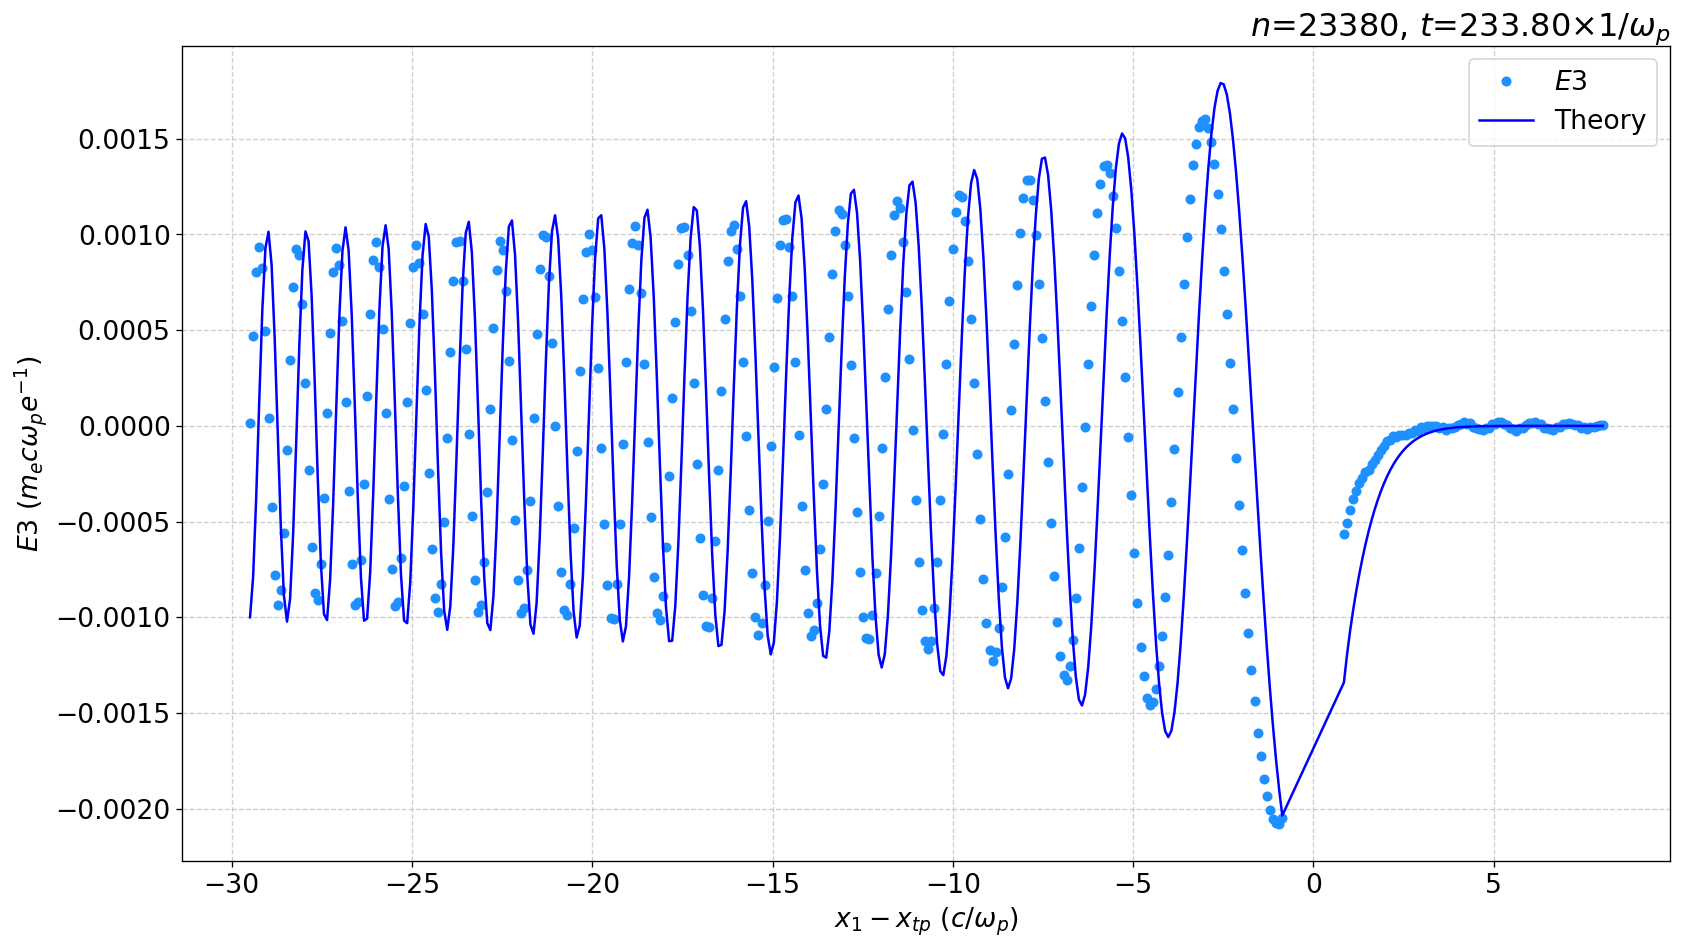

In [103]:
fitdircomp(datavec,dparam,param,Emfun,save=True)